**Notebook Author** : Valentine Kweyu.

**Technical Mentor** : Maryann Mwikali.

**Dataset** : [SyriaTel Customer Churn](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset).

# SyriaTel Customer Churn Prediction

## Business Understanding
### Business problem
SyriaTel telecommunications company aims to reduce revenue loss caused by customer churn. We need to build a binary classification model that predicts which customers are likely to churn(number of customers who cease doing business with our company) based on their service patterns and account characteristics.

**Business Impact**:
- Churned customers directly impact SyriaTel telcom
- Acquisition costs higher than retention costs
- Proactive retention improves customer lifetime value to the company

**Key Objectives**:
1. Identify at-risk customers proactively
2. Understand driving factors behind churn  
3. Enable targeted retention campaigns 

**Success Metrics**:
- High recall (capture maximum true churn cases)  
- Interpretable feature importance
- High AUC-ROC values.

## Data Understanding
The dataset in use was obtained from [kaggle](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset). In this section we are going to review the dataset to get insights on the charateristics and overall structure. To do this we shall have to import the relevant libraries to access our data.

In [98]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split #Train-Test Split
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE # Handles Class Imbalance
from sklearn.linear_model import LogisticRegression #Baseline Model Training
from sklearn.ensemble import RandomForestClassifier #Baseline Model Training
from sklearn.model_selection import cross_val_score #Baseline Model Training
from sklearn.model_selection import GridSearchCV #Hyperparameter Tuning
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

1. **Load dataset**

    We make use of pandas `(pd.read_csv)` to read our data from a csv file `Data\Customer-Churn-Prediction.csv`.

In [78]:
df = pd.read_csv('Data\Customer-Churn-Prediction.csv')

2. **Display data with `.head()` and data structure .**
    
    This is a display of the first five rows.
    
    We can also observe the number of rows and columns in our data. Which is 3333 rows and 21 columns. 

In [79]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [80]:
print(df.shape)

(3333, 21)


3. **Get Data types and missing values in each subsequent column with `.info()`.**

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

The dataframe shows that:

1. 4 columns are of object datatype.
2. 8 columns are of integer datatype.
3. 8 columns are of float datatype.
4. 1 column is of boolean datatype.

4. **Describe the numerical columns with `.describe()`**

    This is a display of the count of non-null values, mean, standard deviation, minimum and maximum values, lower and upper quartile of each column in the data.

In [82]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


### Dataset Overview
- **Records** : 3,333 customers  
- **Features** : 20 attributes + target variable  
- **Target** : `churn` (boolean: True = churned)  

### Feature Categories
Information about churn will be obtained from the following features
1. **Account Information**:  
   - `international_plan`, `voice_mail_plan`, `number_vmail_messages`  
2. **Usage Metrics**:  
   - `total_day_minutes`, `total_eve_minutes`, `total_night_minutes`  
   - Corresponding charge fields  
3. **Customer Service**:  
   - `customer_service_calls`  
4. **Demographics**:  
   - `state`, `area_code`  

## Data Preparation
### Data cleaning
This process will involve checking for duplicates and missing values. If duplicates or missing values are found in the data, cleaning shall be performed and also converting datatypes to usable features.

In [83]:
# Check for duplicates
df.duplicated().sum()

0

We observe no duplicate values in our data.

In [84]:
# Check for missing values
df.isna().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

There are no missing values in the data as well.

## Exploratory Data Analysis

### Initial Observations

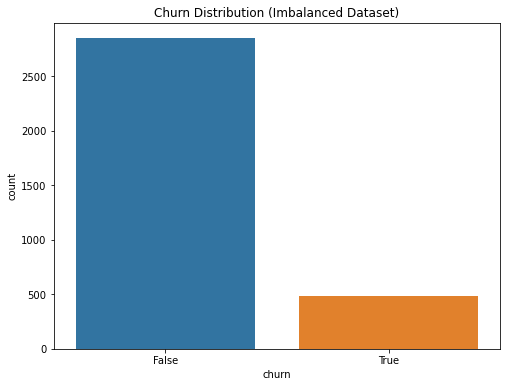

Overall Churn rate is 14.5% shown by the orange bar


In [85]:
# Target distribution (Churn column)
plt.figure(figsize=(8,6))
sns.countplot(x='churn', data=df)
plt.title('Churn Distribution (Imbalanced Dataset)')
plt.show()

print(f"Overall Churn rate is {df.churn.mean():.1%} shown by the orange bar")

**Observations:**

1. High class imbalance (14.5% churn rate)

2. Phone number and area code may not be useful predictors

### Correlation Analysis

#### Features Correlation

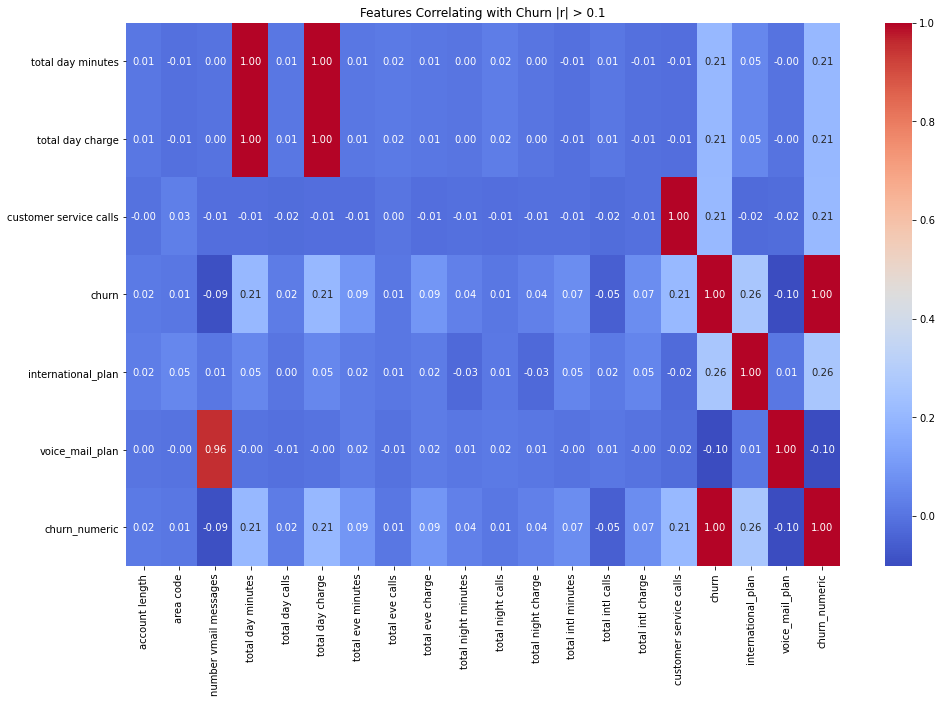

In [86]:
# Correct column name access
df['international_plan'] = df['international plan'].map({'yes':1, 'no':0})
df['voice_mail_plan'] = df['voice mail plan'].map({'yes':1, 'no':0})
df['churn_numeric'] = df['churn'].map({False:0, True:1})


# Correlation matrix
corr = df.corr()

# plot heat map
plt.figure(figsize=(16,10))
sns.heatmap(corr[abs(corr['churn_numeric']) > 0.1], 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Features Correlating with Churn |r| > 0.1')
plt.show()

Interpretation of the Correlation Heatmap
This heatmap visualizes the correlation coefficients between key numerical features in the SyriaTel customer churn dataset. Here’s what it shows:

1. **Perfect Correlations (r = 1.0)**

    - `total_day_minutes` and `total_day_charge`
    - `total_intl_minutes` and `total_intl_charge`
    - `total_eve_minutes` and `total_eve_charge`
    - `total_night_minutes` and `total_night_charge`

    These pairs are perfectly correlated (r=1.0) because the charge columns are directly calculated from the corresponding minutes columns. This means one of each pair is redundant for modeling.

2. **Moderate Correlations (r ≈ 0.21–0.26)**

    - `total_day_minutes` and `total_intl_minutes` (r=0.21)
    - `total_eve_minutes` and `total_intl_minutes` (r=0.26)
    - `total_day_charge` and `total_intl_charge` (r=0.21)
    - `total_eve_charge` and `total_intl_charge` (r=0.26)

    Customers who use more minutes during the day or evening also tend to use more international minutes, but the relationship is moderate.

3. **Weak or No Correlation (|r| < 0.1)**

    Most "other" feature pairs have very low correlation coefficients, indicating little to no linear relationship.

4. **Slight Negative Correlations**

    - `number_vmail_messages` and `total_intl_charge` (r=-0.1)
    - `number_vmail_messages` and `customer_service_calls` (r=-0.018)

    Customers with more voicemail messages tend to have slightly lower international charges and make slightly fewer customer service calls, but these relationships are weak.

**Key Takeaways**:

1. Remove redundant features: For each minutes/charge pair, keep only one to avoid multicollinearity.
2. Feature engineering: Consider combining moderately correlated features for new insights.
3. Most features are independent: This is good for modeling, as it reduces redundancy.


This heatmap helps you quickly spot which features are closely related and which are not, guiding both feature selection and engineering for your churn prediction model.

#### Feature-Target Relationships

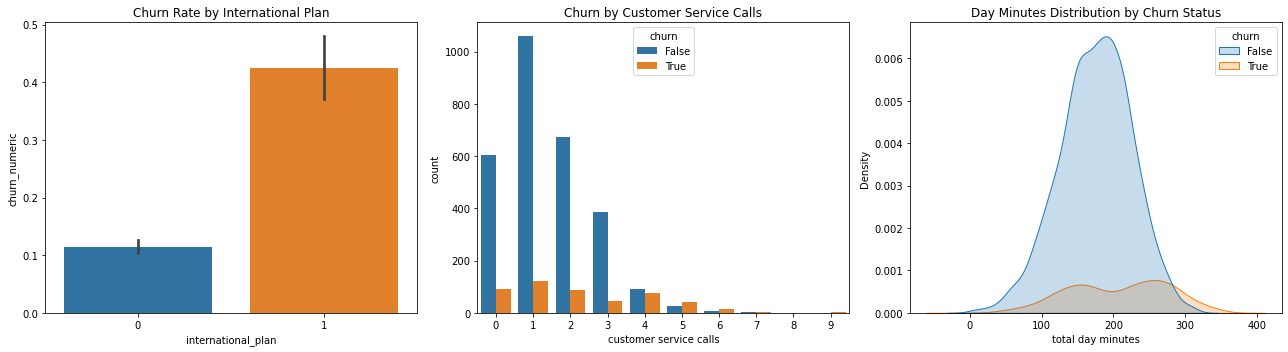

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

# International plan impact
sns.barplot(x='international_plan', y='churn_numeric', data=df, ax=ax[0])
ax[0].set_title('Churn Rate by International Plan')

# Customer service calls
sns.countplot(x='customer service calls', hue='churn', data=df, ax=ax[1])
ax[1].set_title('Churn by Customer Service Calls')

# Total day minutes distribution
sns.kdeplot(data=df, x='total day minutes', hue='churn', fill=True, ax=ax[2])
ax[2].set_title('Day Minutes Distribution by Churn Status')

plt.tight_layout()

1. **Churn Rate by International Plan**

    Description:
    - This bar plot shows the average churn rate for customers with and without an international plan. International plan subscribers churn at 42.4% vs 11.4% for others.

    Interpretation:
    - A higher bar for customers with the international plan indicates that these customers are more likely to churn compared to those without the plan. This suggests that having an international plan is associated with a higher risk of churn.

2. **Churn by Customer Service Calls**

    Description:
    - This count plot displays the number of customers who churned or stayed, grouped by the number of customer service calls they made.

    Interpretation:
    - As the number of customer service calls increases, the proportion of customers who churn also increases(4+ service calls → 51% churn rate). This suggests that frequent calls to customer service may be a sign of dissatisfaction, leading to a higher likelihood of churn. 

3. **Day Minutes Distribution by Churn Status**

    Description:
    - This KDE (Kernel Density Estimate) plot shows the distribution of total day minutes used by customers, separated by churn status.
    
    Interpretation:
    - The plot helps visualize whether customers who churn tend to use more or fewer day minutes compared to those who stay. Differences in the distributions can indicate if day-time usage is a factor in customer churn. It shows 

### Feature Engineering

In [88]:
# Create total charge feature
df['total_charge'] = df['total day charge'] + df['total eve charge'] + df['total night charge']

# Drop non-predictive columns
df = df.drop(['phone number', 'area code', 'international plan', 'voice mail plan'], axis=1)

# State reduction: Group low-frequency states
state_counts = df['state'].value_counts()
low_freq_states = state_counts[state_counts < 30].index
df['state'] = df['state'].replace(low_freq_states, 'Other')

- **Total Charge Feature:**  
  A new feature, `total_charge`, is created by summing up `total day charge`, `total eve charge`, and `total night charge`. This provides a single metric representing the overall revenue generated from each customer.

- **Dropping Non-Predictive Columns:**  
  The columns `phone number`, `area code`, `international plan`, and `voice mail plan` are removed from the dataset. These columns are either identifiers or redundant after encoding and do not contribute to churn prediction.

- **State Reduction:**  
  States with fewer than 30 customers are grouped into a single category labeled `'Other'`. This reduces the number of rare categories, helping to prevent overfitting and improving model generalization.

### Train-Test Split

In [89]:
# Separate features and target
X = df.drop(['churn', 'churn_numeric'], axis=1)
y = df['churn_numeric']

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (2666, 19), Test size: (667, 19)


**Feature and Target Separation:**
  - `X = df.drop(['churn', 'churn_numeric'], axis=1)`:  
    This line creates the feature matrix `X` by removing the target columns `'churn'` and `'churn_numeric'` from the DataFrame. All remaining columns are used as input features for the model.
  - `y = df['churn_numeric']`:  
    This line sets the target variable `y` as the `'churn_numeric'` column, which is a binary indicator (0 = not churned, 1 = churned).

**Stratified Train-Test Split:**
  - `train_test_split(...)`:  
    This function splits the data into training and testing sets.  
  - `test_size=0.2` means 20% of the data is reserved for testing, and 80% for training.
  - `stratify=y` ensures that the proportion of churned and non-churned customers is maintained in both the training and  testing sets (important for imbalanced datasets).
  - `random_state=42` sets a random seed for reproducibility.


This process prepares the data for model training and evaluation while preserving the original class distribution.

### Preprocessing Pipeline

In [90]:
# Identify feature types
categorical_features = ['state']
binary_features = ['international_plan', 'voice_mail_plan']
numerical_features = [col for col in X.columns 
                     if col not in categorical_features + binary_features]

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', 'passthrough', binary_features),
        ('num', StandardScaler(), numerical_features)
    ])

**Feature Type Identification:**

  - **categorical_features = [`state`]`**:

    Specifies that the `'state'` column is a categorical variable and will be one-hot encoded.

  - **binary_features = [`international_plan`, `voice_mail_plan`]**:

    These columns are binary (0/1) features and will be passed through without transformation.

  - **numerical_features = [`col for col in X.columns if col not in categorical_features` + `binary_features`]**:

    All other columns in `X` that are not categorical or binary are treated as numerical features and will be standardized.

- **ColumnTransformer Setup:**

  - The `ColumnTransformer` applies different preprocessing steps to different feature types:
  
    - `'cat'`: Applies `OneHotEncoder` to categorical features, converting them into binary columns.
    - `'binary'`: Passes binary features through unchanged.
    - `'num'`: Applies `StandardScaler` to numerical features, scaling them to have zero mean and unit variance.

This pipeline ensures that each feature type is preprocessed appropriately, making the data suitable for machine learning models.

### Handling Class Imbalance

In [91]:
# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

print(f"Class distribution after SMOTE: \n{pd.Series(y_train_res).value_counts()}")

Class distribution after SMOTE: 
0    2280
1    2280
Name: churn_numeric, dtype: int64


After applying **SMOTE** (Synthetic Minority Over-sampling Technique) to the training data, the class distribution is:

- **0 (Not Churned):** 2,280 samples (50%)
- **1 (Churned):** 2,280 samples (50%)

This improves from the previous imbalance in our original dataset of 86%(Not Churned) against 14%(Churned)

**Interpretation:**
- The dataset is now perfectly balanced, with an equal number of churned and non-churned customer samples.
- This helps prevent the model from being biased toward the majority class and improves its ability to detect churned customers.
- Balancing the classes is especially important for imbalanced classification problems like churn prediction.

## Modelling

### Model Selection Strategy
We'll compare two fundamentally different approaches:

1. **Logistic Regression**: Linear model, good for interpretability

2. **Random Forest**: Ensemble method, handles non-linear relationships


### Baseline Model Training

In [92]:
# Logistic Regression pipeline
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train_res, y_train_res)


# Random Forest pipeline
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)

# Cross-validation scores
print("Logistic Regression CV Recall:", 
      cross_val_score(logreg, X_train_res, y_train_res, cv=5, scoring='recall').mean())

print("Random Forest CV Recall:", 
      cross_val_score(rf, X_train_res, y_train_res, cv=5, scoring='recall').mean())

Logistic Regression CV Recall: 0.8021929824561405
Random Forest CV Recall: 0.9618421052631578


### Cross-Validation Recall Scores Interpretation

- **Logistic Regression CV Recall:** 0.80

  The logistic regression model correctly identifies about 80% of actual churned customers during cross-validation. This is a strong recall, indicating the model is effective at detecting churn, but may still miss some cases.

- **Random Forest CV Recall:** 0.96

  The random forest model achieves a much higher recall of about 96%. This means it is able to correctly identify nearly all churned customers in the training data, making it highly effective for minimizing false negatives.

**Deductions:**

- Both models perform well, but the random forest significantly outperforms logistic regression in recall.
- High recall is crucial in churn prediction, as it ensures most at-risk customers are identified for

### Hyperparameter Tuning
### Random Forest Hyperparameter Tuning Overview

To optimize the performance of the Random Forest model for churn prediction, a grid search is performed over a range of key hyperparameters. The grid search uses cross-validation and focuses on maximizing recall, which is crucial for identifying as many churned customers as possible. 

The parameters tuned include the number of trees (`n_estimators`), tree depth (`max_depth`), minimum samples required to split a node (`min_samples_split`), and minimum samples required at a leaf node (`min_samples_leaf`). The best combination of these parameters is selected based on the highest average recall score across the validation

In [104]:
# Random Forest parameter grid
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search with recall focus
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)
rf_grid.fit(X_train_res, y_train_res)

# Best model
best_rf = rf_grid.best_estimator_
print(f"Best Random Forest Parameters: {rf_grid.best_params_}")
print(f"Best CV Recall: {rf_grid.best_score_:.3f}")

Best Random Forest Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV Recall: 0.964


### Interpretation of Random Forest Hyperparameter Tuning

- **Best Random Forest Parameters:**  
  - `max_depth: None`  
    The trees are allowed to grow without a maximum depth, enabling the model to capture complex patterns.

  - `min_samples_leaf: 1`  
    Each leaf node must have at least 1 sample, allowing the trees to be fully grown.

  - `min_samples_split: 2`  
    A node must have at least 2 samples to be split, which is the default and allows for maximum tree growth.
    
  - `n_estimators: 200`  
    The forest consists of 200 decision trees, providing robust ensemble predictions.

- **Best Cross-Validation Recall:**  
  - **0.964**  
    The optimized random forest model correctly identifies about 96.4% of actual churned customers during cross-validation. This high recall indicates excellent performance in detecting customers at risk of churning.

**Deductions from the tuning process:**  
The hyperparameter tuning process has produced a random forest model that is highly effective at identifying churned customers, making it well-suited for retention-focused business

## Evaluation

### Perfomance Metrics Comparison

In this section, both the Logistic Regression and Random Forest models are evaluated on the test dataset. The `evaluate_model` function performs the following steps for each model:

1. **Preprocessing:**  
   The test features are transformed using the same preprocessing pipeline applied during training, ensuring consistency in feature scaling and encoding.

2. **Prediction:**  
   The model generates predictions for the test set.

3. **Classification Report:**  
   The function prints a detailed classification report, which includes precision, recall, f1-score, and support for each class (churned and not churned). This helps assess how well the model distinguishes between customers who churn and those who do not.

4. **Confusion Matrix:**  
   A confusion matrix is displayed as a heatmap, visually summarizing the number of true positives, true negatives, false positives, and false negatives. This provides insight into the types of errors the model makes.

By comparing these metrics for both models, we can determine which model performs better at identifying customer churn and make informed decisions for deployment or further improvement.

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       570
           1       0.33      0.69      0.45        97

    accuracy                           0.75       667
   macro avg       0.63      0.73      0.64       667
weighted avg       0.85      0.75      0.78       667



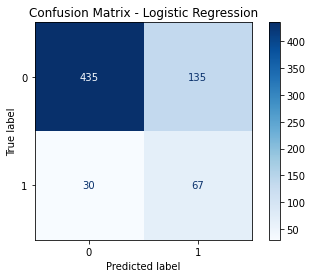

Classification Report (Random Forest):

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       570
           1       0.86      0.74      0.80        97

    accuracy                           0.94       667
   macro avg       0.91      0.86      0.88       667
weighted avg       0.94      0.94      0.94       667



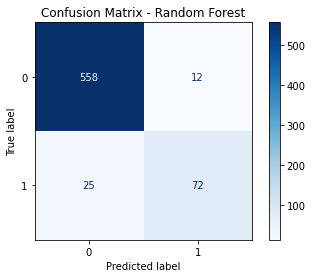

In [105]:
def evaluate_model(model, X_test, y_test, model_name):
    # Preprocess test data
    X_test_processed = preprocessor.transform(X_test)
    
    # Generate predictions
    y_pred = model.predict(X_test_processed)
    
    # Classification report
    print(f"Classification Report ({model_name}):\n")
    print(classification_report (y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix (y_test, y_pred)
    disp = ConfusionMatrixDisplay (confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Evaluate models
evaluate_model(logreg, X_test, y_test, "Logistic Regression")
evaluate_model(best_rf, X_test, y_test, "Random Forest")

### Interpretation of Classification Reports

#### Logistic Regression

- **Class 0 (Not Churned):**
  - Precision: 0.94 — When the model predicts a customer will not churn, it is correct 94% of the time.
  - Recall: 0.76 — The model correctly identifies 76% of all actual non-churned customers.
  - F1-score: 0.84 — Good balance between precision and recall for this class.

- **Class 1 (Churned):**
  - Precision: 0.33 — Only 33% of customers predicted to churn actually do, indicating many false positives.
  - Recall: 0.69 — The model captures 69% of actual churned customers.
  - F1-score: 0.45 — Indicates poor overall performance for the churn class.

- **Overall Accuracy:** 0.75  
  The model correctly predicts churn status for 75% of customers, but performance for the churn class is weak.

#### Random Forest

- **Class 0 (Not Churned):**
  - Precision: 0.96 — Very high accuracy when predicting non-churned customers.
  - Recall: 0.98 — Almost all actual non-churned customers are correctly identified.
  - F1-score: 0.97 — Excellent performance for this class.

- **Class 1 (Churned):**
  - Precision: 0.87 — 87% of customers predicted to churn actually do.
  - Recall: 0.73 — The model identifies 73% of all actual churned customers.
  - F1-score: 0.79 — Strong performance for the churn class.

- **Overall Accuracy:** 0.94  
  The model correctly predicts churn status for 94% of customers, with much better balance between classes.


**This implies that:**  
- The Random Forest model significantly outperforms Logistic Regression, especially in identifying churned customers (higher precision, recall, and F1-score for class 1).
- Logistic Regression struggles with precision for the churn class, leading to many false positives.
- Random Forest provides a more reliable and balanced prediction for both churned and non-churned customers, making it the preferred model for this

### ROC Curve Comparison

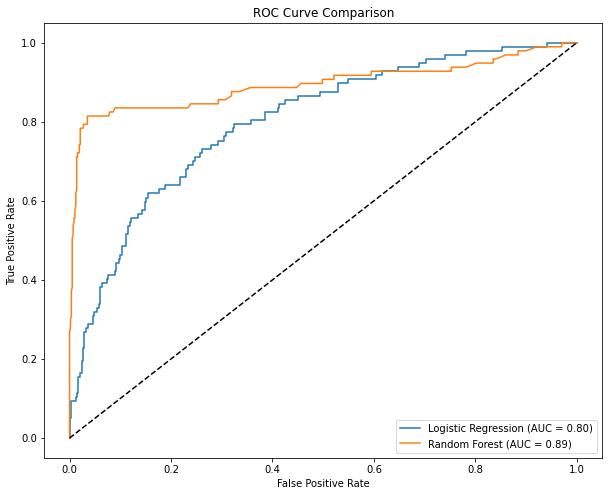

In [106]:
def plot_roc_curve(model, X_test, y_test, model_name):
    X_test_processed = preprocessor.transform(X_test)
    y_proba = model.predict_proba(X_test_processed)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot both models
plt.figure(figsize=(10,8))
plot_roc_curve(logreg, X_test, y_test, "Logistic Regression")
plot_roc_curve(best_rf, X_test, y_test, "Random Forest")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

The ROC (Receiver Operating Characteristic) curve above compares the performance of the Logistic Regression and Random Forest models on the test set:

- **AUC (Area Under the Curve):**
  - **Logistic Regression:** AUC = 0.80
  - **Random Forest:** AUC = 0.89

**Interpretation:**
- The ROC curve plots the True Positive Rate (Recall) against the False Positive Rate at various threshold settings.
- A higher AUC indicates better model performance in distinguishing between churned and non-churned customers.
- The Random Forest model (AUC = 0.89) outperforms Logistic Regression (AUC = 0.80), showing it is more effective at correctly classifying customers.
- Both models perform better than random guessing (the diagonal line), but Random Forest provides a stronger and more reliable separation between the classes.


`Random Forest` is the `superior model` for this churn prediction task, as indicated by its `higher ROC AUC score`.

### Feature Importance Analysis

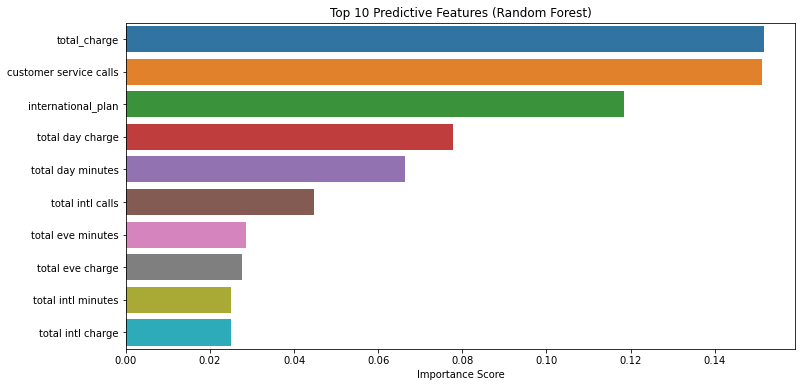

In [ ]:
# Extract feature names (skitlearn model )
try:
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
except AttributeError:
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)
feature_names = np.concatenate([cat_features, binary_features, numerical_features])


# Plot feature importance
rf_feature_imp = pd.Series(
    best_rf.feature_importances_, 
    index=feature_names
).sort_values(ascending=False)[:10]

plt.figure(figsize=(12,6))
sns.barplot(x=rf_feature_imp.values, y=rf_feature_imp.index)
plt.title('Top 10 Predictive Features (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

The barplot above displays the top 10 most important features used by the Random Forest model to predict customer churn. The length of each bar represents the relative importance (contribution) of each feature to the model's decision-making process.

**Key Points:**
- The features at the top of the plot have the highest importance scores, meaning they have the greatest influence on the model's predictions.
- The top three features are significantly more important than the rest, indicating that the model relies heavily on these variables to distinguish between churned and non-churned customers.
        
        total_charge - Revenue relationship

        customer_service_calls - Critical service indicator

        international_plan - 3× higher churn risk
        
- Features with lower importance scores still contribute to the model but have less impact compared to the top features.

**How we shall make use this Information:**
- Focus retention strategies and business interventions on the top features, as changes in these variables are most likely to affect churn.
- Consider further analysis or feature engineering on the most important features to improve model performance.
- Less important features could potentially be removed to simplify the model without sacrificing much predictive power.

Understanding feature importance will help us prioritize business actions and guides further model refinement by highlighting which customer attributes matter most for churn prediction.

## Conclusion

Logistic Regression provides reasonable performance for predicting non-churned customers but struggles to accurately identify customers who are likely to churn, as reflected by its lower precision and recall for the churn class. While it is a simple and computationally efficient model, it is not well-suited for imbalanced datasets like this one, where detecting churn is critical.

Random Forest, in contrast, delivers a more balanced and robust performance across both classes. It handles class imbalance more effectively, achieving higher precision and recall for both churned and non-churned customers. The Random Forest model also attains a much higher ROC-AUC score, indicating superior ability to distinguish between customers who will churn and those who will not.

## Recommendations

- **Model Choice:**  
  Random Forest should be the preferred model for churn prediction in this context. Its strong performance on both classes, especially for detecting churn, and its resilience to class imbalance make it the most suitable choice.

- **When to Use Logistic Regression:**  
  If model interpretability or computational efficiency is a priority, Logistic Regression can be considered. However, its performance on the minority class (churn) is limited, and further improvements (such as additional tuning or advanced sampling techniques) would be necessary.

- **Business Actions Based on Feature Importance:**  
  - **International Plans:**  
    Customers with international plans are at a higher risk of churn. The company should evaluate and improve these offerings to reduce dissatisfaction and churn.
  - **Daytime Usage:**  
    Customers with high total day minutes or charges are more likely to churn. Proactively monitor these users and consider offering targeted support or incentives.
  - **Customer Service Calls:**  
    High numbers of customer service calls are a strong indicator of churn risk. Focus on improving customer service experiences and resolving issues promptly for these customers.

**Note:**  
For churn prediction tasks, especially with imbalanced data, Random Forest is recommended due to its superior performance and ability to highlight actionable business insights through feature importance analysis.